## Importing Relevant Libraries

In [179]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import PIL.Image as image
import pathlib
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from mlxtend.plotting import plot_decision_regions

In [180]:
os.getcwd()

'C:\\Users\\HP\\Desktop\\pandas\\deep learning\\celeb_image_classification'

In [181]:
os.chdir('C:\\Users\\HP\\Desktop\\pandas\\deep learning\\celeb_image_classification')

In [182]:
photo_dir='./celeb_photos'

In [183]:
photo_dir=pathlib.Path(photo_dir)
photo_dir

WindowsPath('celeb_photos')

In [184]:
phs=list(photo_dir.glob('*/*'))

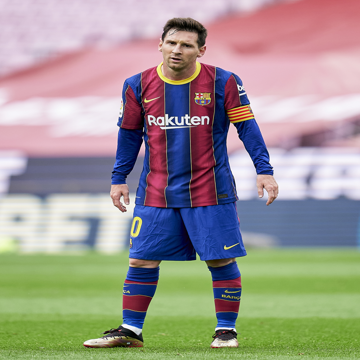

In [185]:
image.open(str(phs[90])).resize((360,360))

## Creating dictionaries for the images and their labels

In [186]:
images_dict={
    'messi':list(photo_dir.glob('messi/*')),
    'kohli':list(photo_dir.glob('virat_kohli/*')),
    'ronaldo':list(photo_dir.glob('ronaldo/*')),
    'vettel':list(photo_dir.glob('vettel/*')),
    'PV Sindhu':list(photo_dir.glob('pv_sindhu/*')),
}

In [187]:
photo_labels={
    'messi':0,
    'kohli':1,
    'ronaldo':2,
    'vettel':3,
    'PV Sindhu':4,
}

## Splitting data intoTrain and Test

In [188]:
x,y=[],[]

for celeb_name,celeb_images in images_dict.items():
    for img in celeb_images:
        image=cv2.imread(str(img))
        try:
            resized=cv2.resize(image,(360,360))
        except:
            continue
        x.append(resized)
        y.append(photo_labels[celeb_name])

In [189]:
x=np.array(x)
y=np.array(y)

In [190]:
from sklearn.utils import shuffle
X=shuffle(x)

In [191]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [192]:
x_train_scaled=x_train/255.0
x_test_scaled=x_test/255.0

In [193]:
x_train.shape

(357, 360, 360, 3)

In [194]:
y_train.shape

(357,)

## Using Transfer learning to train the model

In [195]:
feature_vector="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [196]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(360,360,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

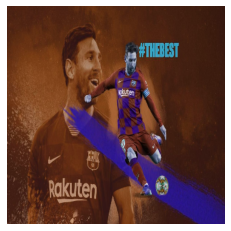

In [197]:
plt.imshow(x[0])
plt.axis('off')
plt.show()

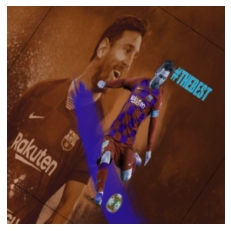

In [198]:
plt.imshow(data_augmentation(x)[0].numpy().astype("uint8"))
plt.axis('off')
plt.show()

In [199]:
resnet=tf.keras.Sequential([
    data_augmentation,
    hub.KerasLayer(feature_vector,input_shape=(360,360,3),trainable=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5)
])

In [200]:
resnet.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 360, 360, 3)       0         
_________________________________________________________________
keras_layer_4 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [201]:
resnet.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

In [202]:
history=resnet.fit(x_train_scaled,y_train,epochs=10,validation_data=(x_test_scaled,y_test),callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss'))

Epoch 1/10
12/12 [==============================] - 74s 6s/step - loss: 1.8319 - acc: 0.2717 - val_loss: 1.5045 - val_acc: 0.2521
Epoch 2/10
12/12 [==============================] - 76s 6s/step - loss: 1.5833 - acc: 0.3361 - val_loss: 1.2001 - val_acc: 0.5630
Epoch 3/10
12/12 [==============================] - 83s 7s/step - loss: 1.2259 - acc: 0.5210 - val_loss: 1.0648 - val_acc: 0.6639
Epoch 4/10
12/12 [==============================] - 79s 7s/step - loss: 1.1452 - acc: 0.5434 - val_loss: 0.9698 - val_acc: 0.6807
Epoch 5/10
12/12 [==============================] - 80s 7s/step - loss: 1.0037 - acc: 0.6078 - val_loss: 0.8669 - val_acc: 0.7311
Epoch 6/10
12/12 [==============================] - 79s 7s/step - loss: 0.8873 - acc: 0.6555 - val_loss: 0.8276 - val_acc: 0.6975
Epoch 7/10
12/12 [==============================] - 78s 7s/step - loss: 0.8231 - acc: 0.6835 - val_loss: 0.7881 - val_acc: 0.7479
Epoch 8/10
12/12 [==============================] - 71s 6s/step - loss: 0.7278 - acc: 0.74

resnet.evaluate(x_test_scaled,y_test)

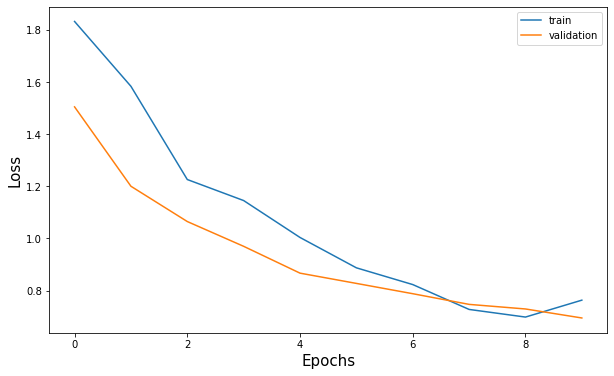

In [203]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epochs',size=15)
plt.ylabel('Loss',size=15)
plt.legend()
plt.show()

## Predictions

In [204]:
preds=resnet.predict(x_test_scaled)

In [205]:
preds

array([[-1.3527172e+00, -1.3976190e+00,  3.4186286e-01, -1.5240133e+00,
        -2.4645677e+00],
       [ 5.9998494e-01, -1.0860692e+00, -1.3452510e+00, -2.7648575e+00,
        -2.0773406e+00],
       [-3.3376451e+00, -2.1834826e+00, -1.2176535e+00,  2.1427708e+00,
        -2.7877955e+00],
       [-1.2510939e+00, -6.9359833e-01, -4.4625825e-01,  2.0666378e+00,
        -3.1400623e+00],
       [-6.2575407e+00, -2.2462864e+00, -2.2772329e+00,  1.3293548e+00,
        -2.4576299e+00],
       [-3.0072734e+00, -8.5844231e-01, -1.4458365e+00, -1.4971864e+00,
        -1.3121235e-01],
       [ 2.6329595e-01, -2.3464103e+00, -1.7601707e+00, -1.0792329e+00,
        -8.4118003e-01],
       [-1.0649472e+00, -2.1212931e+00, -1.9021363e+00,  1.2151387e+00,
        -3.4061589e+00],
       [ 1.2522596e+00, -1.8375900e+00, -7.4557710e-01, -2.5344837e+00,
        -2.6912367e+00],
       [-2.4764807e+00, -3.0149546e+00, -2.8740683e+00, -2.3159859e+00,
        -1.7080346e-01],
       [-1.1436944e+00,  4.738

In [206]:
y_pred=[np.argmax(i) for i in preds]

In [207]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred,y_test)

0.7983193277310925

In [208]:
classes=['messi','kohli','ronaldo','vettel','sindhu']

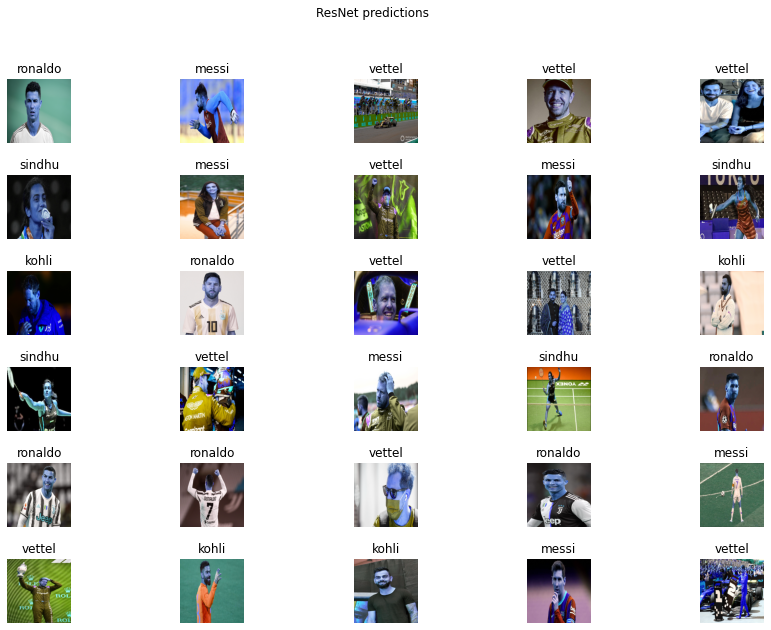

In [209]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(x_test_scaled[n])
    plt.title(classes[y_pred[n]])
    plt.axis('off')
    plt.suptitle("ResNet predictions")

## Confusion matrix

In [210]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

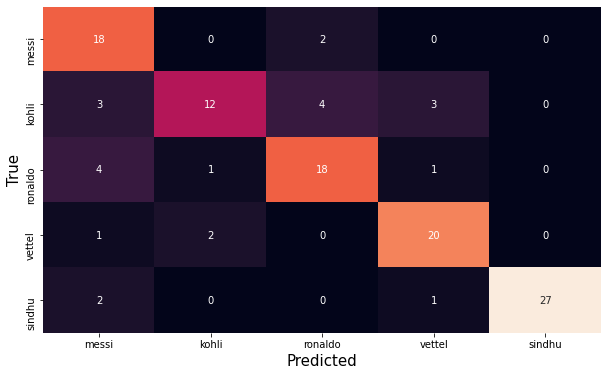

In [211]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,xticklabels=classes,yticklabels=classes,cbar=False)
plt.xlabel('Predicted', size=15)
plt.ylabel('True', size=15)
plt.show()

## Classification Report

In [212]:
from sklearn.metrics import classification_report

In [213]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        20
           1       0.80      0.55      0.65        22
           2       0.75      0.75      0.75        24
           3       0.80      0.87      0.83        23
           4       1.00      0.90      0.95        30

    accuracy                           0.80       119
   macro avg       0.80      0.79      0.79       119
weighted avg       0.81      0.80      0.80       119

